In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
from matplotlib.markers import MarkerStyle
from matplotlib.path import Path
import btrack, numpy as np, pandas as pd
from btrack.constants import BayesianUpdates
from scipy.stats import zscore
from scipy.signal import savgol_filter

from scipy.stats import binned_statistic_2d

import anndata as an
import scanpy as sc

# tracking algs
import trackpy as tp

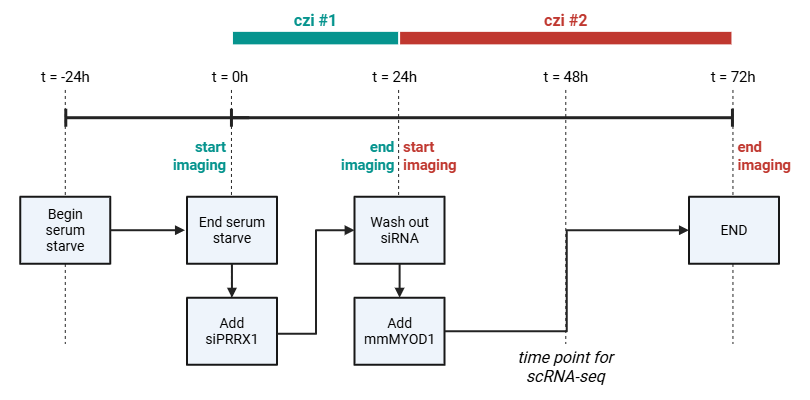

In [2]:
%%time
dpath = "/scratch/indikar_root/indikar1/shared_data/hybrid_segmentation/regionprops/"
file_list = glob.glob(f"{dpath}*_*_*.csv") # exclude the test image

df_list = []

for fpath in file_list:
    basename = os.path.basename(fpath).replace(".csv", "")
    stage, condition, scene, _ = basename.split("_")
    
    df = pd.read_csv(fpath)
    df['basename'] = basename
    df['stage'] = int(stage)
    df['condition'] = condition
    df['scene'] = scene
    
    print(f"\t{basename} {df.shape=}")

    df_list.append(df)


df = pd.concat(df_list)
print(f"{df.shape=}")
df.head()

	02_siPRRX1_B3_props df.shape=(188240, 49)
	01_mmMYOD1_D4_props df.shape=(35964, 49)
	01_control_D2_props df.shape=(31271, 49)
	01_hybrid_C3_props df.shape=(49123, 49)
	01_mmMYOD1_D3_props df.shape=(33663, 49)
	02_hybrid_C6_props df.shape=(123894, 49)
	02_hybrid_C4_props df.shape=(145648, 49)
	01_hybrid_C4_props df.shape=(64240, 49)
	02_mmMYOD1_D4_props df.shape=(72217, 49)
	02_siPRRX1_B4_props df.shape=(198826, 49)
	02_hybrid_C3_props df.shape=(133759, 49)
	01_hybrid_C6_props df.shape=(57297, 49)
	01_control_C2_props df.shape=(39967, 49)
	02_mmMYOD1_D3_props df.shape=(68484, 49)
	01_siPRRX1_B4_props df.shape=(80394, 49)
	02_control_C2_props df.shape=(94187, 49)
	01_siPRRX1_B3_props df.shape=(70595, 49)
	01_control_B2_props df.shape=(40213, 49)
	02_control_D2_props df.shape=(65965, 49)
	02_control_B2_props df.shape=(91039, 49)
df.shape=(1684986, 49)
CPU times: user 8.67 s, sys: 952 ms, total: 9.62 s
Wall time: 15.9 s


label   area  bbox-0  bbox-1  bbox-2  bbox-3  bbox_area   centroid-0  \
0      1  139.0     770     366     786     378      192.0   777.402878   
1      2   92.0     513    2953     524    2964      121.0   517.945652   
2      3  131.0    2553     722    2566     735      169.0  2558.908397   
3      4  638.0    2205    1117    2234    1148      899.0  2219.070533   
4      5  146.0     702     806     719     818      204.0   710.260274   

    centroid-1  eccentricity  ...  mKate_max  mKate_min   mKate_sum  time  \
0   371.733813      0.787459  ...   0.211949   0.101667   29.239852     0   
1  2957.891304      0.204520  ...   0.211949   0.003333   11.038021     0   
2   727.664122      0.528127  ...   0.211949   0.005833   16.582590     0   
3  1131.733542      0.746750  ...   0.211949   0.211949  135.223725     0   
4   811.657534      0.793181  ...   0.211949   0.127783   30.855447     0   

   seg_channel_idx  seg_channel_name             basename  stage  condition  \
0                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   
1                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   
2                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   
3                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   
4                2               Cy5  02_siPRRX1_B3_props      2    siPRRX1   

   scene  
0     B3  
1     B3  
2     B3  
3     B3  
4     B3  

[5 rows x 49 columns]

In [3]:
columns = [
    'label', 
    'time',
    'stage', 
    'condition',
    'scene',
]

print(df[columns].head().to_string(index=False))

 label  time  stage condition scene
     1     0      2   siPRRX1    B3
     2     0      2   siPRRX1    B3
     3     0      2   siPRRX1    B3
     4     0      2   siPRRX1    B3
     5     0      2   siPRRX1    B3


In [4]:
# counts = (
#     df.groupby(["time", "stage", "condition", "scene"])
#       .size()
#       .reset_index(name="n_cells")
# )

# # plot with stage split into subplots
# g = sns.relplot(
#     data=counts,
#     x="time", y="n_cells",
#     hue="condition",      # color by condition
#     style="scene",        # style by scene
#     kind="line",
#     col="stage",          # separate subplot per stage
#     col_wrap=2,           # wrap into 2 columns
#     facet_kws={'sharey': False}  # allow different y scales if needed
# )

# g.set_axis_labels("Timepoint", "Cell count")
# g.set_titles("Stage {col_name}")
# plt.show()



In [5]:
# counts = (
#     df.groupby(["time", "stage", "condition", "scene"])
#       .size()
#       .reset_index(name="n_cells")
# )

# # shift stage 2 times to follow after stage 1
# max_time_stage1 = counts.loc[counts["stage"] == 1, "time"].max()
# counts["time_shifted"] = counts["time"] + (
#     (counts["stage"] == 2) * (max_time_stage1 + 1)
# # )

# # line plot, one axis
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 6, 3.5


# sns.lineplot(
#     data=counts,
#     x="time_shifted", 
#     y="n_cells",
#     hue="condition",
#     marker="o",
#     markeredgecolor='none',
#     markersize=1,
# )

# plt.xlabel("Timepoint")
# plt.ylabel("Cell count")

# # add vertical line to mark stage transition
# plt.axvline(max_time_stage1 + 0.5, ls="--", c="k", alpha=0.5)

# plt.tight_layout()
# plt.show()

# PRRX1 KO in Mice  
Citation: [Nature Communications (2022)](https://www.nature.com/articles/s41467-022-30484-4)

**Prrx1** drives a broad range of myofibroblast-like functions, linking fibroblast homeostasis to activated, contractile states.

- **Fibroblasts**  
  Baseline mesenchymal cells that secrete extracellular matrix (ECM) proteins (e.g., collagen, fibronectin) and maintain tissue structure. They are spindle-shaped, motile, and typically quiescent under normal conditions.  

- **Myofibroblasts**  
  Activated fibroblasts with contractile properties that arise during wound healing, fibrosis, or remodeling. They express **α-smooth muscle actin (α-SMA)**, form stress fibers, and remodel ECM. Their contractility aids wound closure and increases tissue stiffness, but persistent activation promotes pathological fibrosis.


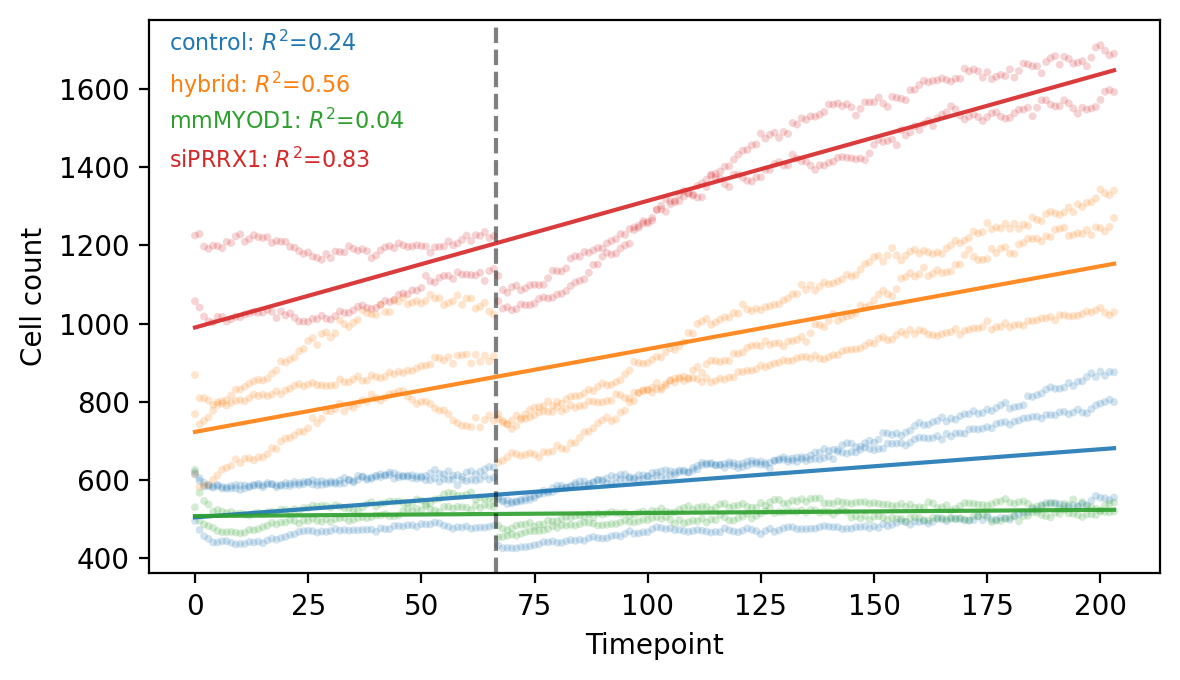

In [6]:
counts = (
    df.groupby(["time", "stage", "condition", "scene"])
      .size()
      .reset_index(name="n_cells")
)

# shift stage 2 times to follow after stage 1
max_time_stage1 = counts.loc[counts["stage"] == 1, "time"].max()
counts["time_shifted"] = counts["time"] + (
    (counts["stage"] == 2) * (max_time_stage1 + 1)
)

# --- scatter first, with a fixed palette we can reuse for lines ---
levels = counts["condition"].unique()
palette = dict(zip(levels, sns.color_palette(n_colors=len(levels))))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (6, 3.5)

ax = sns.scatterplot(
    data=counts,
    x="time_shifted",
    y="n_cells",
    hue="condition",
    ec="none",
    alpha=0.2,
    legend=False,
    s=8,
    palette=palette,
)

# --- per-condition fit, plot, and collect R^2 ---
labels = []
for cond in levels:
    d = counts.loc[counts["condition"] == cond, ["time_shifted", "n_cells"]].dropna()
    if len(d) < 2:
        continue

    x = d["time_shifted"].to_numpy()
    y = d["n_cells"].to_numpy()

    # least-squares line y = m x + b
    m, b = np.polyfit(x, y, 1)
    yhat = m * x + b

    # R^2
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # draw fit line
    xx = np.linspace(x.min(), x.max(), 100)
    ax.plot(xx, m * xx + b, lw=1.5, color=palette[cond], alpha=0.9)

    # save for annotation
    labels.append((cond, r2))

# --- put annotations in top-left, stacked with colors ---
x0, y0 = 0.02, 0.98
for i, (cond, r2) in enumerate(labels):
    ax.text(
        x0, y0 - i*0.07,    # step down by 0.07 each line
        f"{cond}: $R^2$={r2:.2f}",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=8,
        color=palette[cond]
    )
    
# stage transition
max_time_stage1 = counts.loc[counts["stage"] == 1, "time"].max()
ax.axvline(max_time_stage1 + 0.5, ls="--", c="k", alpha=0.5)

ax.set_xlabel("Timepoint")
ax.set_ylabel("Cell count")
plt.tight_layout()
plt.show()

/tmp/ipykernel_291203/1564729477.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(


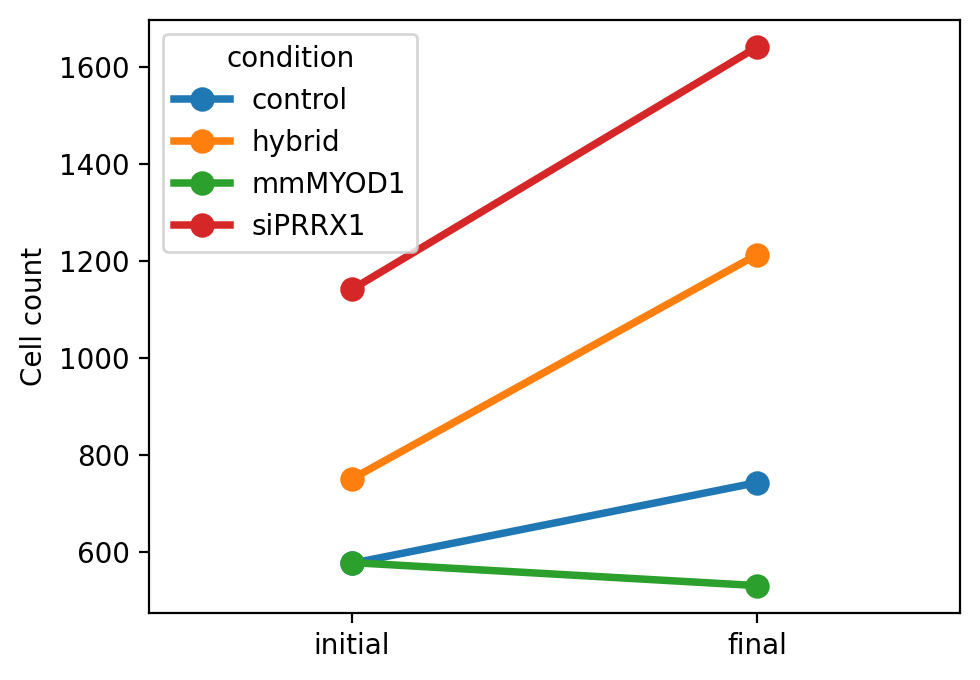

In [7]:
# get global initial and final counts per (condition, scene)
endpoints = (
    counts.groupby(["condition", "scene"])
    .agg(initial=("n_cells", "first"), final=("n_cells", "last"))
    .reset_index()
)

# melt for plotting
endpoints_melt = endpoints.melt(
    id_vars=["condition", "scene"],
    value_vars=["initial", "final"],
    var_name="timepoint", value_name="n_cells"
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (5, 3.5)

# plot points
sns.pointplot(
    data=endpoints_melt,
    x="timepoint",
    y="n_cells",
    hue="condition",
    ci=None,
)

plt.xlabel("")
plt.ylabel("Cell count")
plt.tight_layout()
plt.show()

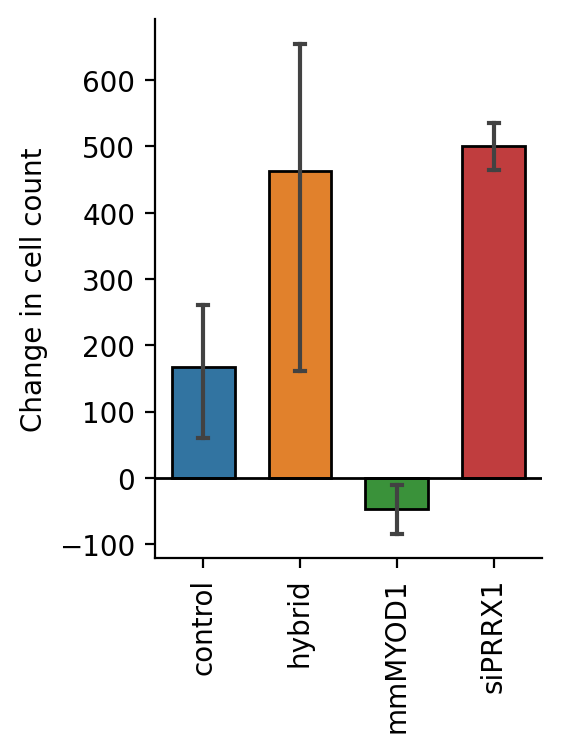

In [8]:
# compute net change in counts
endpoints["delta"] = endpoints["final"] - endpoints["initial"]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (2.5, 3.5)

# bar plot of total change
sns.barplot(
    data=endpoints,
    x="condition",
    y="delta",
    hue="condition",
    width=0.65,
    ec='k',
    capsize=0.1,
    err_kws={"linewidth": 1.5},
)

plt.axhline(0, color="black", lw=1)
plt.ylabel("Change in cell count")
plt.xlabel("")
plt.xticks(rotation=90)
sns.despine()
plt.show()


# By Stage

   stage condition scene  initial  final  delta
0      1   control    B2      620    631     11
1      1   control    C2      614    606     -8
2      1   control    D2      495    483    -12
3      1    hybrid    C3      615    751    136
4      1    hybrid    C4      768   1023    255


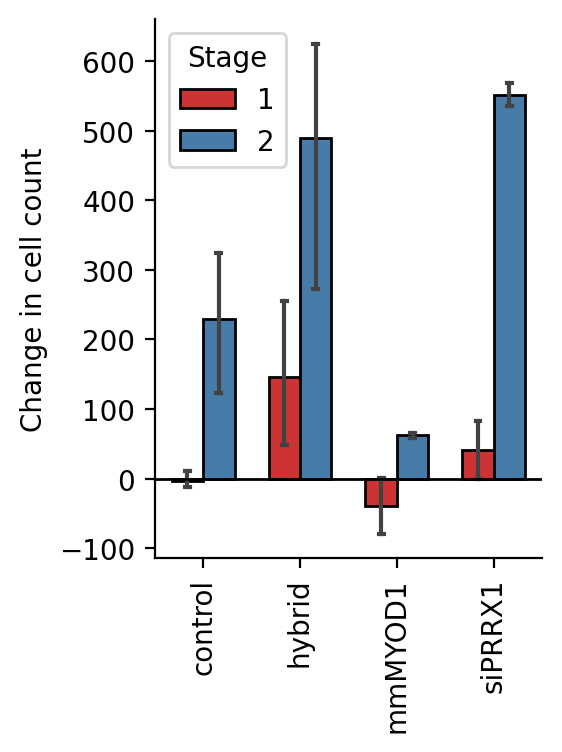

In [9]:
results = []

for stage, group in counts.groupby('stage'):
    # get first and last n_cells per (condition, scene)
    endpoints = (
        group.groupby(["condition", "scene"])
        .agg(tmin=("time", "min"),
             initial=("n_cells", "first"),
             tmax=("time", "max"),
             final=("n_cells", "last"))
        .reset_index()
    )
    # compute difference
    endpoints["delta"] = endpoints["final"] - endpoints["initial"]
    endpoints["stage"] = stage

    endpoints = endpoints[['stage', 'condition', 'scene', 'initial', 'final', 'delta']]
    results.append(endpoints)

results = pd.concat(results)
print(results.head().to_string())

sns.barplot(
    data=results,
    x='condition',
    y='delta',
    hue='stage',
    width=0.65,
    ec='k',
    palette='Set1',
    capsize=0.1,
    err_kws={"linewidth": 1.5},
)

plt.axhline(0, color="black", lw=1)
sns.move_legend(plt.gca(), loc='best', title='Stage')
plt.ylabel("Change in cell count")
plt.xlabel("")
plt.xticks(rotation=90)
sns.despine()
plt.show()


# Simple, static cell cycle prediction

<timed exec>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
<timed exec>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


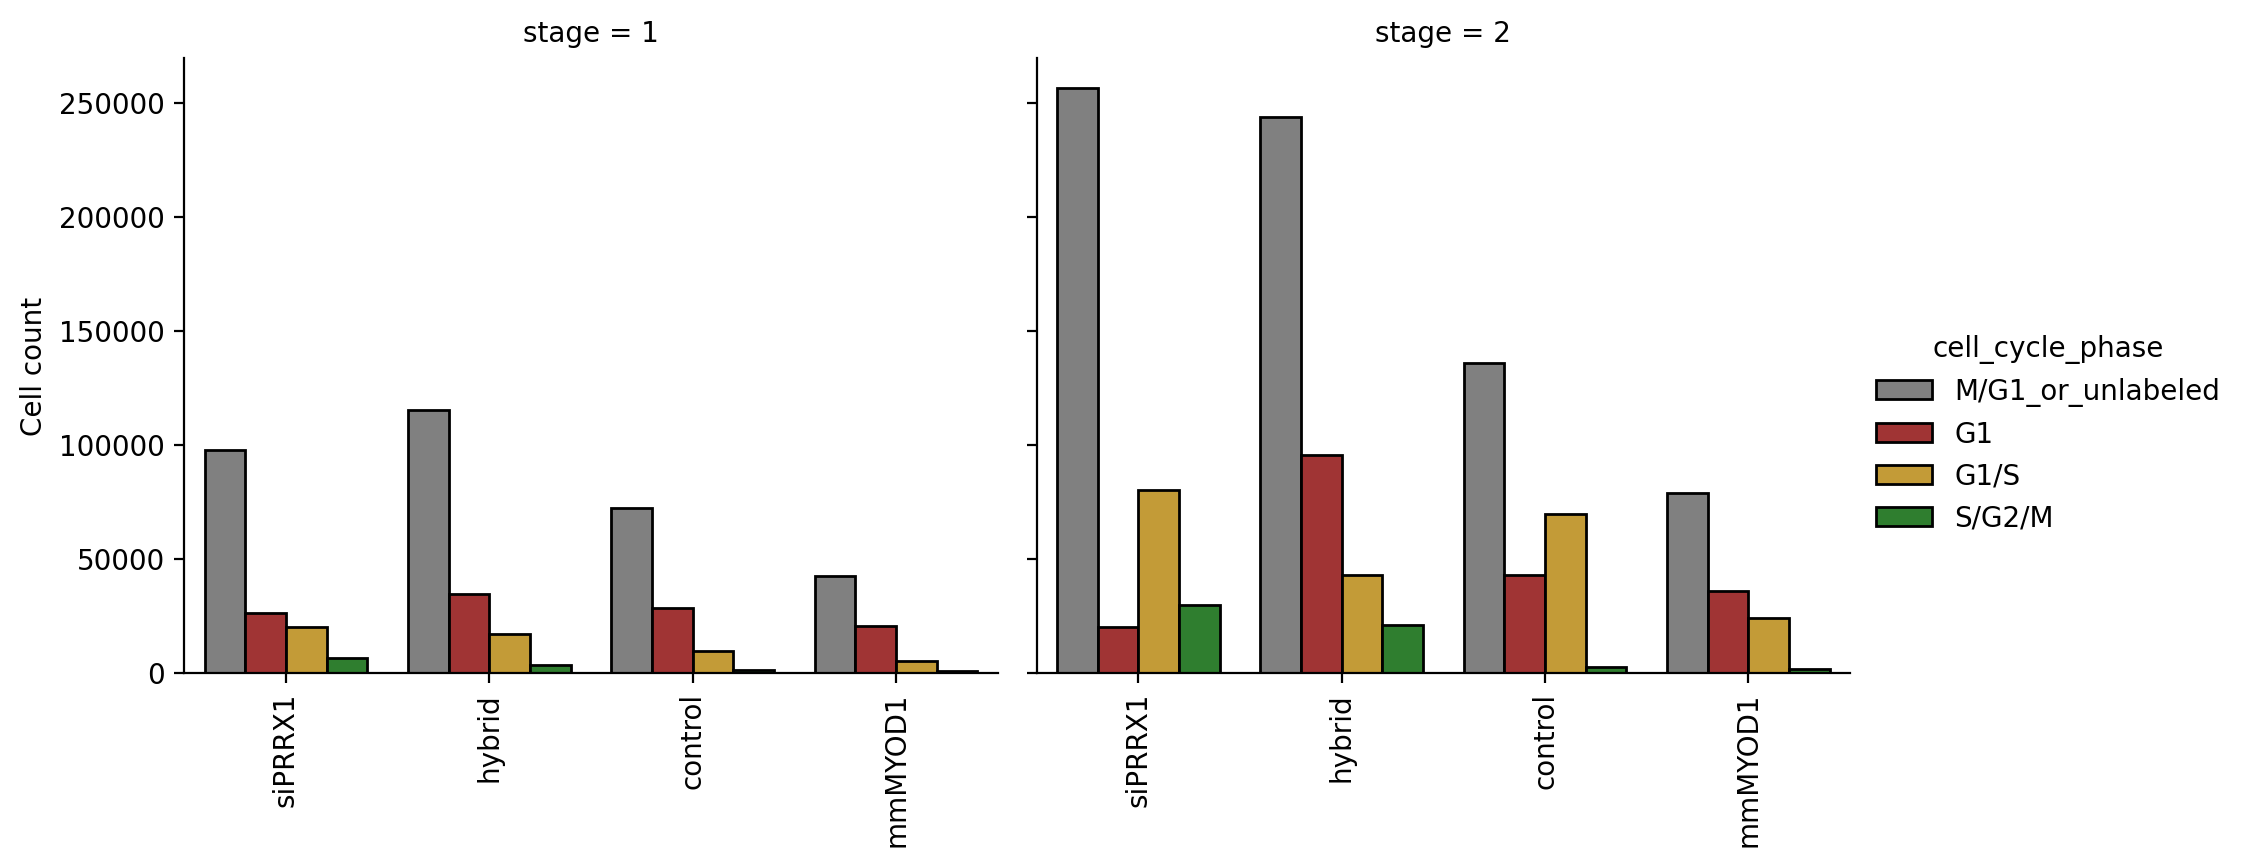

CPU times: user 11 s, sys: 2.21 s, total: 13.2 s
Wall time: 13.2 s


In [10]:
%%time
pdf = df.copy()

pdf['TaGFP_norm'] = (pdf['TaGFP_mean'] - pdf['TaGFP_mean'].min()) / (pdf['TaGFP_mean'].max() - pdf['TaGFP_mean'].min())
pdf['mKate_norm'] = (pdf['mKate_mean'] - pdf['mKate_mean'].min()) / (pdf['mKate_mean'].max() - pdf['mKate_mean'].min())

def classify_cell(row, th_low=0.2, th_high=0.5):
    g, r = row['TaGFP_norm'], row['mKate_norm']

    if r > th_high and g < th_low:
        return "G1"
    elif g > th_high and r < th_low:
        return "S/G2/M"
    elif g > th_high and r > th_high:
        return "G1/S"
    else:
        return "M/G1_or_unlabeled"

pdf['cell_cycle_phase'] = pdf.apply(classify_cell, axis=1)

# aggregate
phase = (
    pdf[['cell_cycle_phase', 'condition', 'stage']]
    .value_counts()
    .reset_index(name='count')
)

# facet by stage
g = sns.catplot(
    data=phase,
    x='condition',
    y='count',
    hue='cell_cycle_phase',
    col='stage',
    kind='bar',
    palette=['grey', 'firebrick', 'goldenrod', 'forestgreen'],
    ec='k',
    height=4,
    aspect=1.2
)

# tidy up each panel
g.set_axis_labels("", "Cell count")
for i, ax in enumerate(g.axes.flat):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()

plt.show()

# Tracking (trackpy)

In [11]:
# shift stage 2 times to follow after stage 1
max_time_stage1 = df.loc[df["stage"] == 1, "time"].max()
df["time_shifted"] = df["time"] + (
    (df["stage"] == 2) * (max_time_stage1 + 1)
)

print(df[['label', 'time', 'time_shifted', 'centroid_x_px','centroid_y_px', 'basename', 'stage', 'condition',
       'scene']].head().to_string(index=False))

 label  time  time_shifted  centroid_x_px  centroid_y_px            basename  stage condition scene
     1     0            67     371.733813     777.402878 02_siPRRX1_B3_props      2   siPRRX1    B3
     2     0            67    2957.891304     517.945652 02_siPRRX1_B3_props      2   siPRRX1    B3
     3     0            67     727.664122    2558.908397 02_siPRRX1_B3_props      2   siPRRX1    B3
     4     0            67    1131.733542    2219.070533 02_siPRRX1_B3_props      2   siPRRX1    B3
     5     0            67     811.657534     710.260274 02_siPRRX1_B3_props      2   siPRRX1    B3


In [12]:
%%time
# rename for trackpy
pdf = df.rename(columns={"time_shifted":"frame","centroid_x_px":"x","centroid_y_px":"y"}).copy()

trajectories = {}
for (cond, scene), g in pdf.groupby(["condition","scene"]):
    print(f"Tracking: {(cond, scene)}")
    g = g.sort_values("frame")
    linked = tp.link_df(g, search_range=55, memory=5, adaptive_stop=True)  # <-- tune 30,2
    linked["condition"], linked["scene"] = cond, scene

    print(f"\traw: {linked.shape=}")
    # drop very short tracks
    linked = tp.filter_stubs(linked, threshold=10)
    print(f"\tfiltered: {linked.shape=}")
    trajectories[(cond, scene)] = linked
    
print(trajectories.keys())

# example
key = list(trajectories.keys())[0]
print(f"{trajectories[key].shape=}")
trajectories[key].head()

Frame 203: 1690 trajectories present.
	raw: linked.shape=(279220, 51)
	filtered: linked.shape=(272887, 51)
dict_keys([('control', 'B2'), ('control', 'C2'), ('control', 'D2'), ('hybrid', 'C3'), ('hybrid', 'C4'), ('hybrid', 'C6'), ('mmMYOD1', 'D3'), ('mmMYOD1', 'D4'), ('siPRRX1', 'B3'), ('siPRRX1', 'B4')])
trajectories[key].shape=(128243, 51)
CPU times: user 42.4 s, sys: 2.74 s, total: 45.1 s
Wall time: 45.2 s


label   area  bbox-0  bbox-1  bbox-2  bbox-3  bbox_area   centroid-0  \
frame                                                                         
0        281  175.0    1351     884    1368     900      272.0  1359.102857   
0        282  131.0     281     203     298     216      221.0   288.404580   
0        283  126.0     126     244     135     262      162.0   130.261905   
0        284  122.0     447     218     457     234      160.0   451.590164   
0        285  131.0    2276    1611    2295    1620      171.0  2285.068702   

        centroid-1  eccentricity  ...  mKate_sum  time  seg_channel_idx  \
frame                             ...                                     
0       891.297143      0.820879  ...   1.733333     0                2   
0       208.885496      0.900031  ...   1.169167     0                2   
0       252.238095      0.896553  ...   1.013333     0                2   
0       225.614754      0.863106  ...  22.457769     0                2   
0      1615.206107      0.890651  ...   1.248333     0                2   

       seg_channel_name             basename  stage  condition  scene  frame  \
frame                                                                          
0                   Cy5  01_control_B2_props      1    control     B2      0   
0                   Cy5  01_control_B2_props      1    control     B2      0   
0                   Cy5  01_control_B2_props      1    control     B2      0   
0                   Cy5  01_control_B2_props      1    control     B2      0   
0                   Cy5  01_control_B2_props      1    control     B2      0   

       particle  
frame            
0             0  
0             1  
0             2  
0             3  
0             4  

[5 rows x 51 columns]

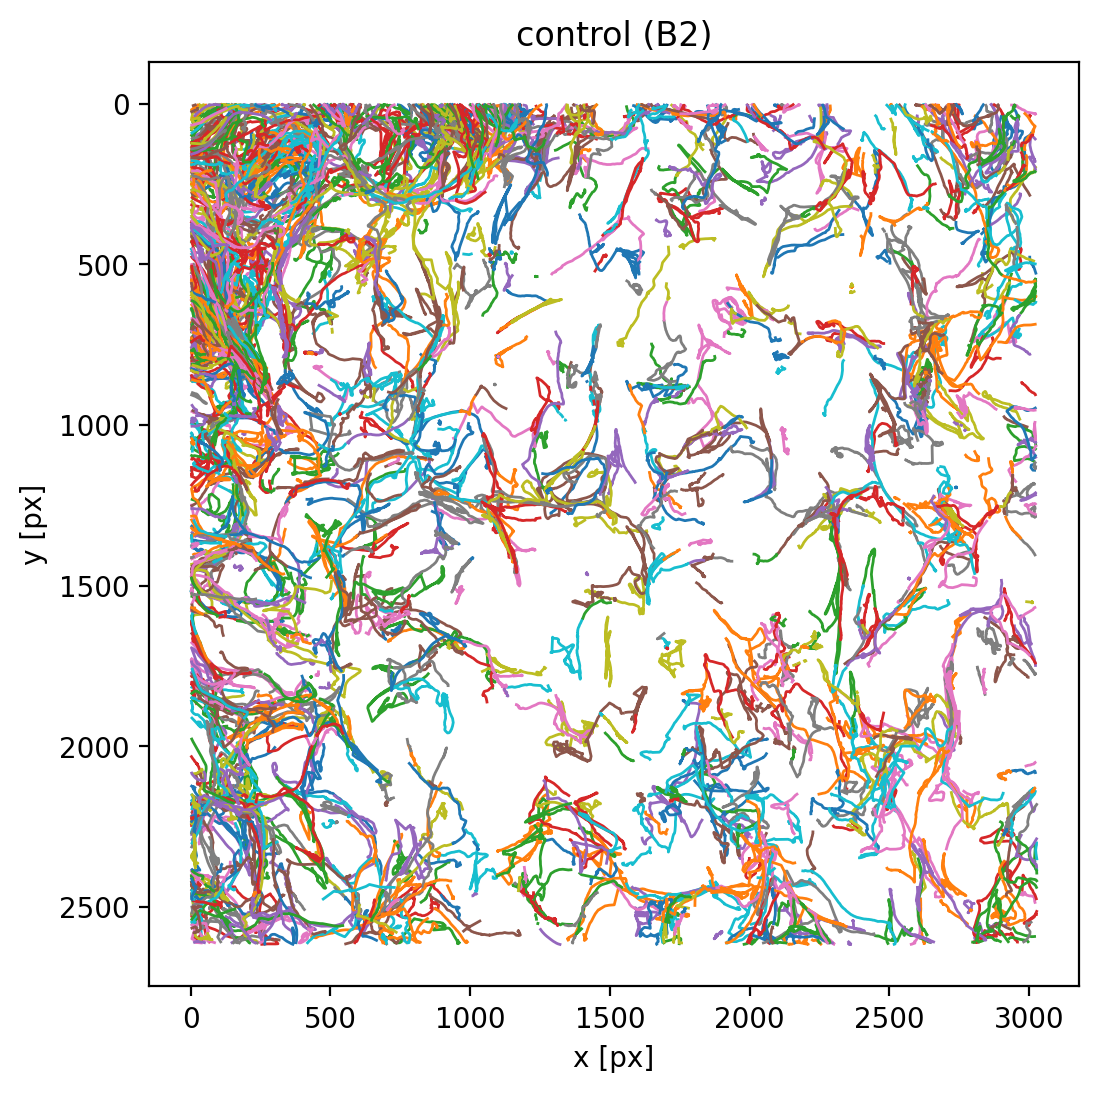

In [13]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

fig, ax = plt.subplots()

key = list(trajectories.keys())[0]
traj = trajectories[key].copy()
title = f"{key[0]} ({key[1]})"

tp.plot_traj(
    traj, 
    colorby='particle',
    ax=ax
)
ax.set_title(title)
plt.show()

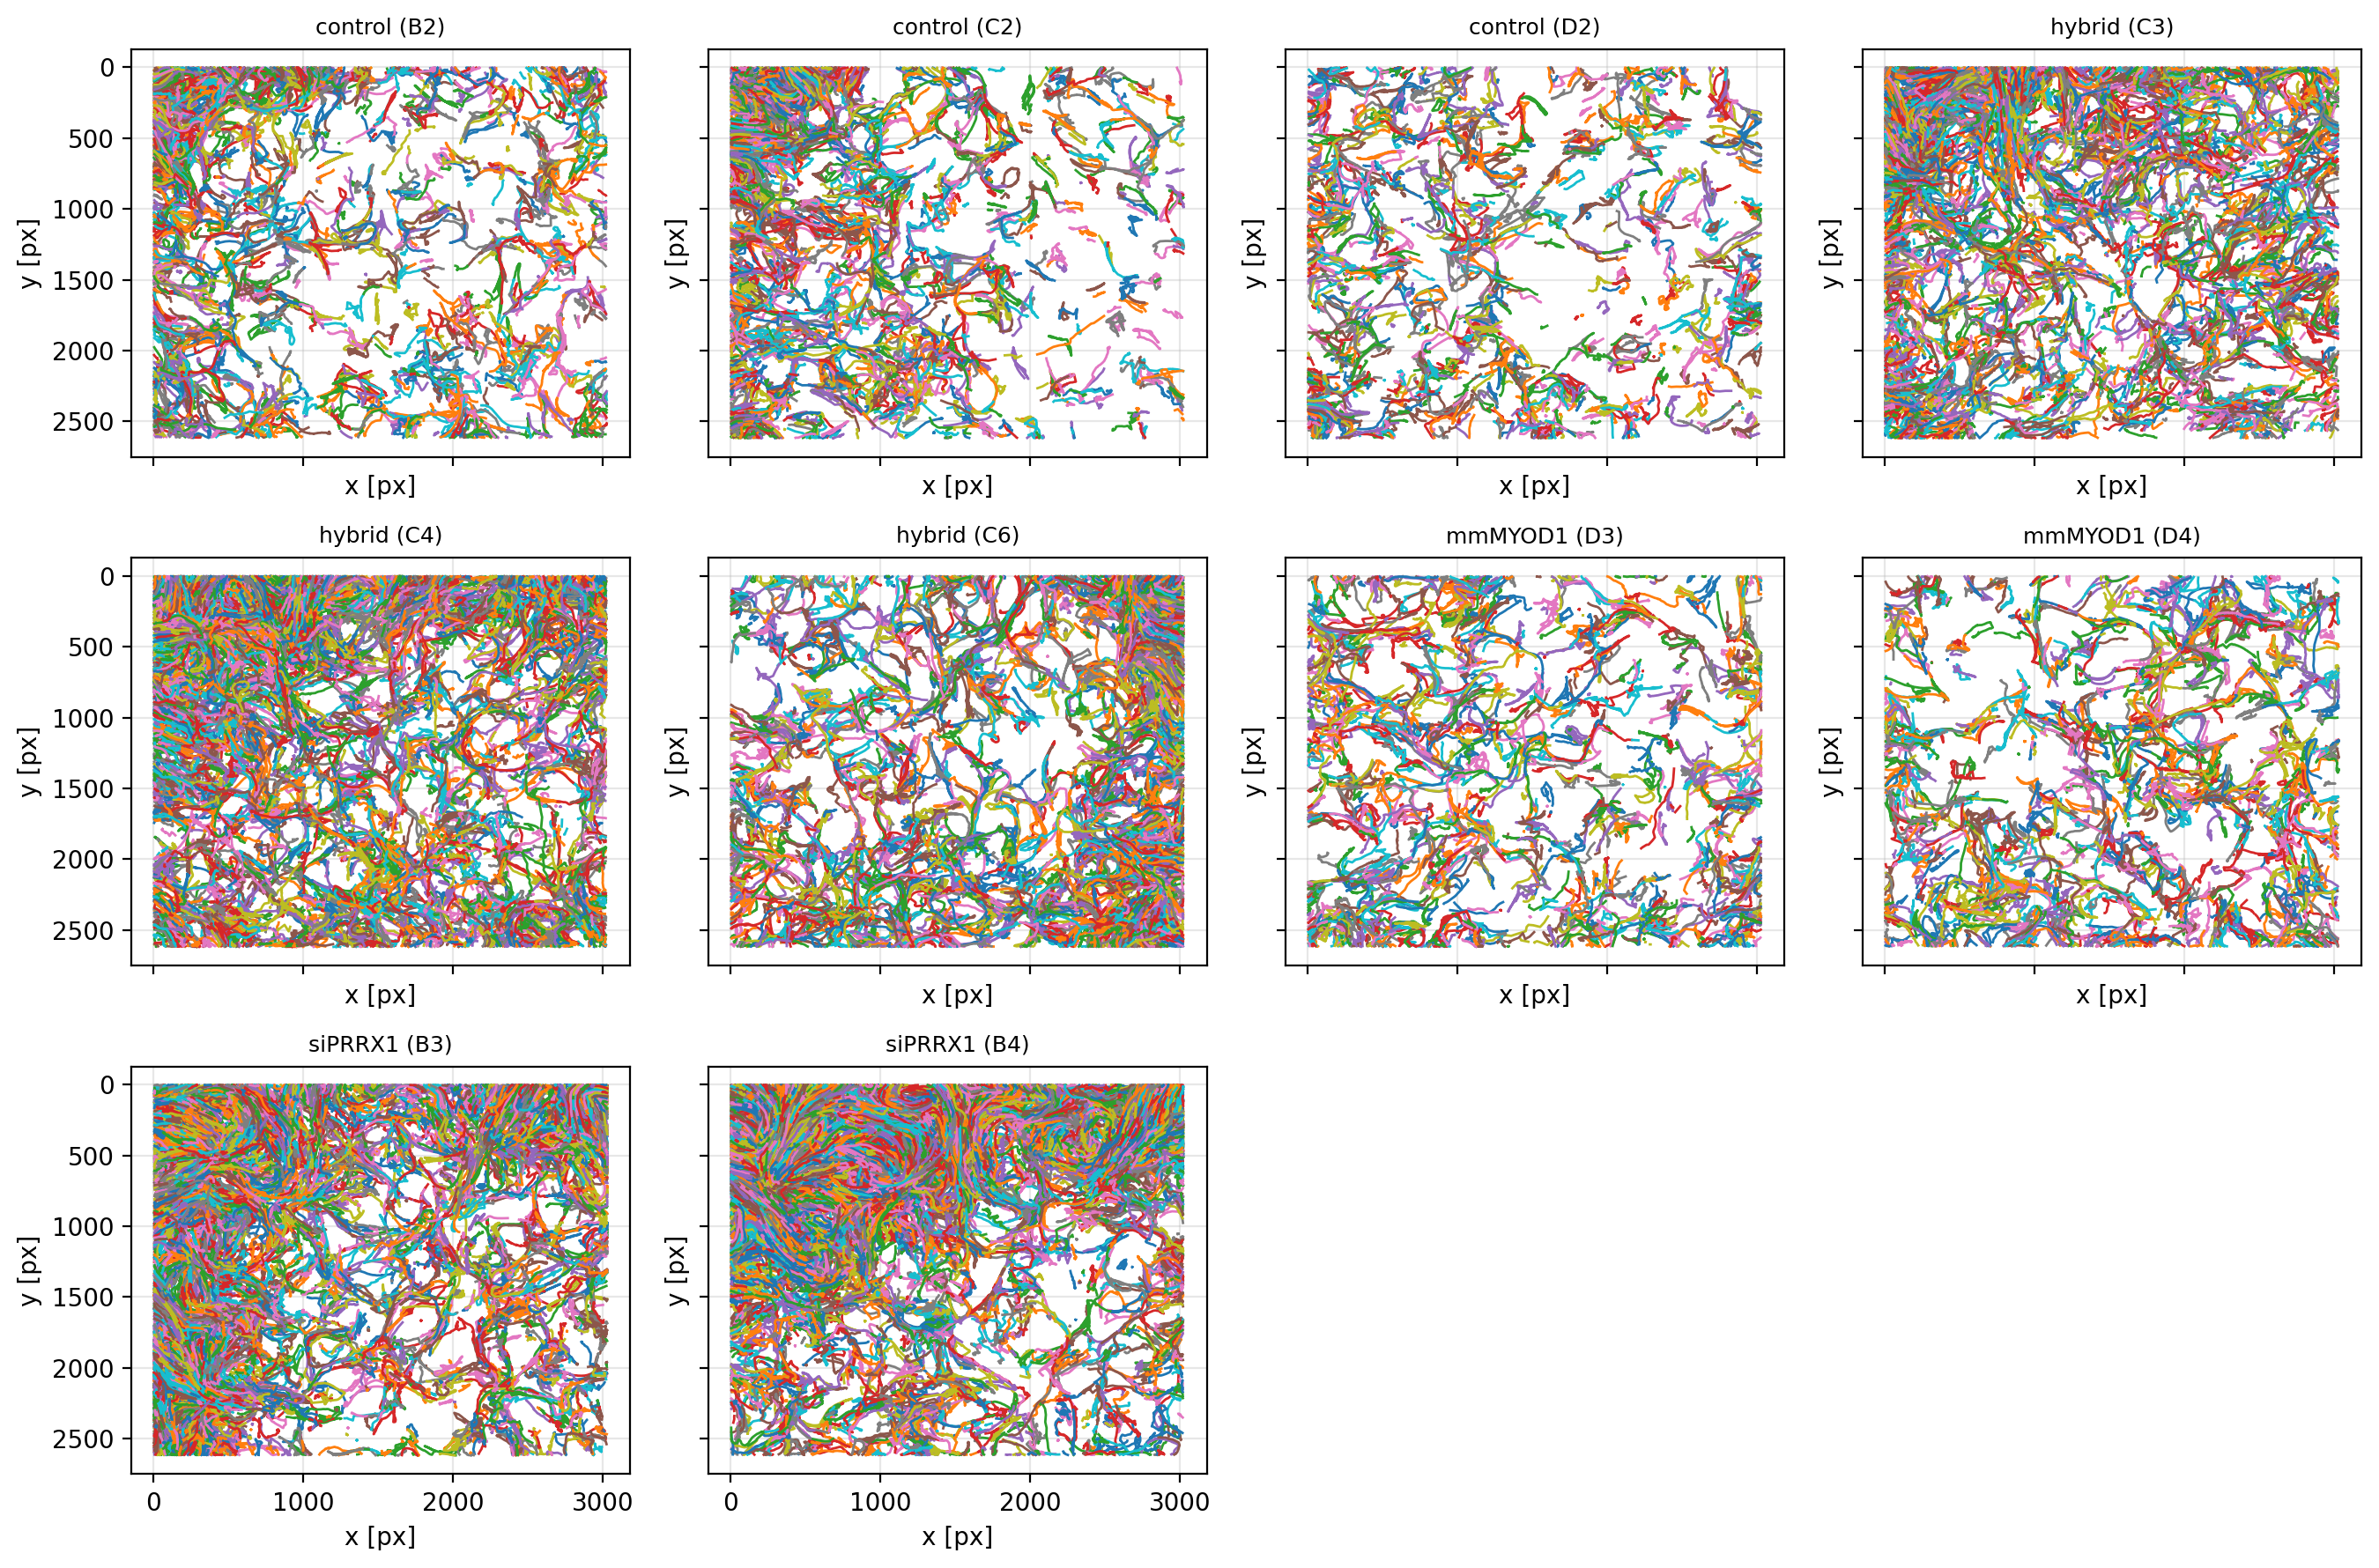

CPU times: user 21.9 s, sys: 398 ms, total: 22.3 s
Wall time: 22.4 s


In [14]:
%%time
plt.rcParams['figure.dpi'] = 200

# grid size
n = len(trajectories)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(3.4*ncols, 3.0*nrows), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

for ax in axes:
    ax.axis('off')  # hide unused, will turn on when plotting

for i, (key, traj) in enumerate(trajectories.items()):
    ax = axes[i]
    ax.axis('on')

    tp.plot_traj(traj, colorby='particle', ax=ax)

    # title from dict key (tuple or not)
    if isinstance(key, tuple) and len(key) >= 2:
        title = f"{key[0]} ({key[1]})"
    else:
        title = str(key)
    ax.set_title(title, fontsize=9)
    ax.grid(True, alpha=0.3)

# hide any leftover empty axes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Total distance

In [15]:
df['time_shifted'].max()

203

In [16]:
%%time

results = []

for key, traj in trajectories.items():
    print(key)
    # compute ensemble mean squared displacement
    disp = tp.motion.imsd(traj, mpp=1, fps=1, max_lagtime=df['time_shifted'].max())
    disp = disp.max(axis=0).reset_index()
    disp.columns = ['cell', 'max_dist']
    disp['condition'] = key[0]
    disp['scene'] = key[1]
    results.append(disp)

results = pd.concat(results)
results.head()

('control', 'B2')
('control', 'C2')
('control', 'D2')
('hybrid', 'C3')
('hybrid', 'C4')
('hybrid', 'C6')
('mmMYOD1', 'D3')
('mmMYOD1', 'D4')
('siPRRX1', 'B3')
('siPRRX1', 'B4')
CPU times: user 1min 12s, sys: 773 ms, total: 1min 13s
Wall time: 1min 13s


cell       max_dist condition scene
0     0    9383.755528   control    B2
1     1   23870.278921   control    B2
2     2  157342.769093   control    B2
3     3  189822.102362   control    B2
4     4  218375.653648   control    B2

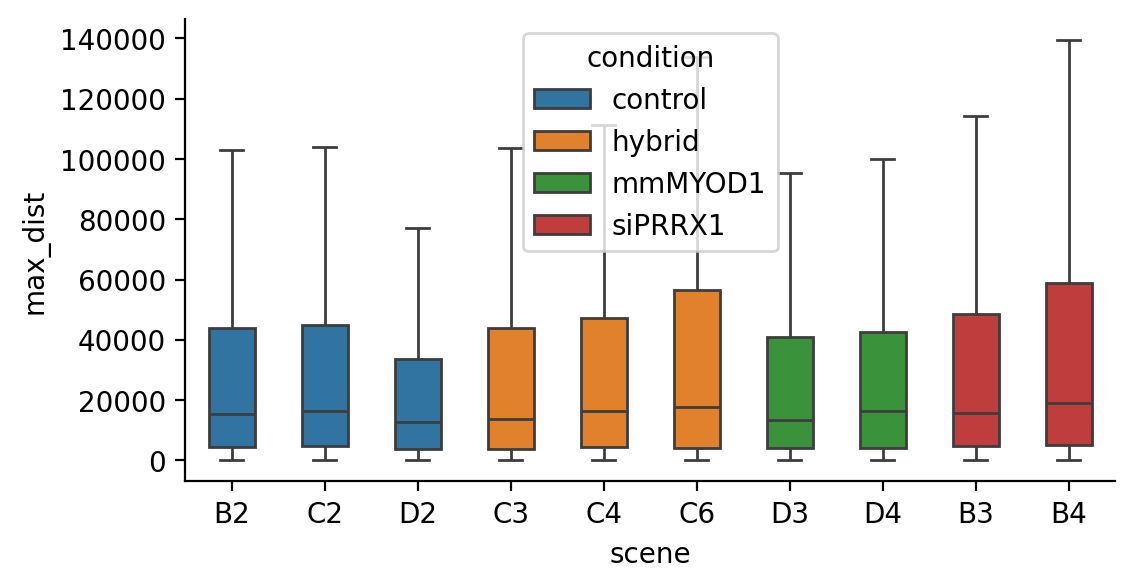

In [17]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3

sns.boxplot(
    data=results,
    x='scene',
    y='max_dist',
    hue='condition',
    width=0.5,
    showfliers=False,
)

sns.despine()
# plt.yscale('log')

# Vector Field

xc shape: (202,)
yc shape: (175,)
Ux shape: (175, 202)
Uy shape: (175, 202)
mask shape: (175, 202)
nx, ny: 202 175


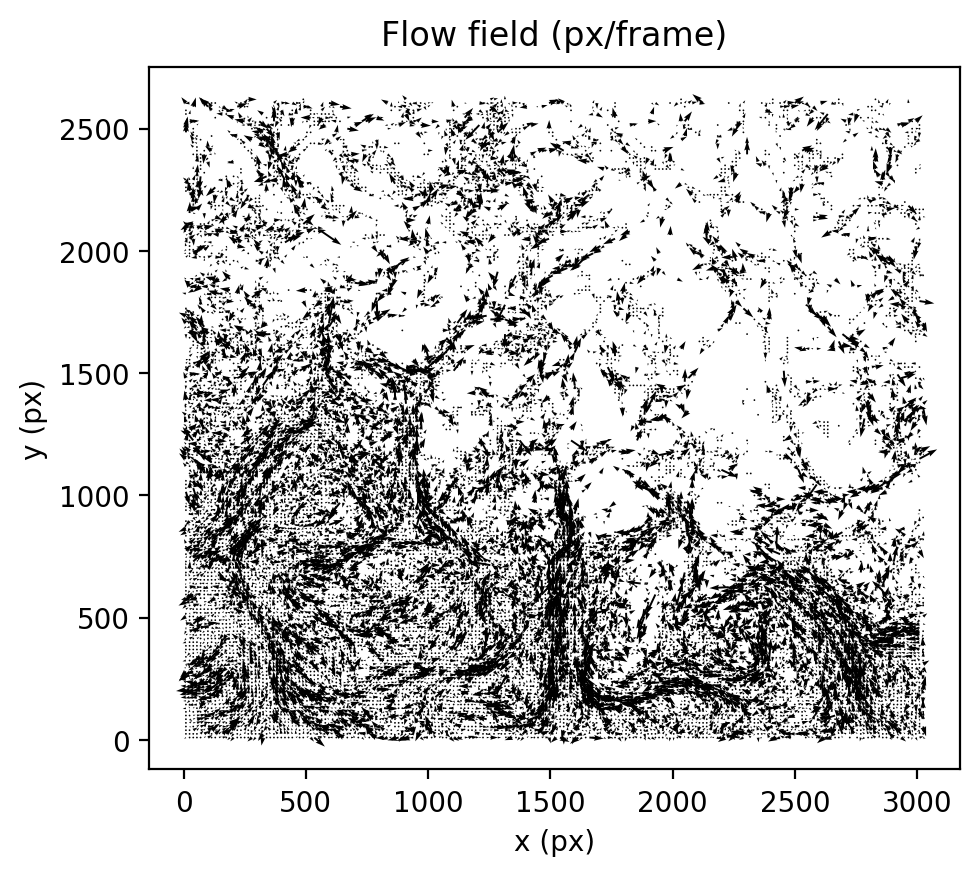

In [18]:
def vector_field_from_traj(traj: pd.DataFrame, grid=50, min_count=3, per_time=True):
    # --- defuse index/column name collision ---
    idx_name = getattr(traj.index, "name", None)
    if idx_name is not None and idx_name in traj.columns:
        # rename the index to avoid "cannot insert <name>, already exists"
        t = traj.copy()
        t.index = t.index.rename(f"{idx_name}_index")
        df = t.reset_index()
    else:
        # safe either way
        df = traj.reset_index().copy()

    # ensure sorting by particle then frame column
    if "frame" not in df.columns and idx_name == "frame":
        # if there was no 'frame' col originally, keep the index copy
        df = df.rename(columns={f"{idx_name}_index": "frame"})
    df = df.sort_values(["particle", "frame"]).copy()

    
    df['dx'] = df.groupby('particle')['x'].diff()
    df['dy'] = df.groupby('particle')['y'].diff()
    df['dt'] = df.groupby('particle')['frame'].diff()

    steps = df.dropna(subset=['dx','dy','dt']).copy()
    steps = steps[np.isfinite(steps[['dx','dy','dt']]).all(axis=1)]
    if per_time:
        steps = steps[steps['dt'] > 0]
        steps['ux'] = steps['dx'] / steps['dt']
        steps['uy'] = steps['dy'] / steps['dt']
    else:
        steps['ux'] = steps['dx']; steps['uy'] = steps['dy']

    # grid
    xedges = np.arange(traj['x'].min(), traj['x'].max() + grid, grid, dtype=float)
    yedges = np.arange(traj['y'].min(), traj['y'].max() + grid, grid, dtype=float)

    # mean velocity per bin (robust to 3- or 4-tuple return)
    Ux = binned_statistic_2d(steps['x'], steps['y'], steps['ux'],
                             statistic='mean', bins=[xedges, yedges])[0]
    Uy = binned_statistic_2d(steps['x'], steps['y'], steps['uy'],
                             statistic='mean', bins=[xedges, yedges])[0]
    ones = np.ones(len(steps), dtype=float)
    N  = binned_statistic_2d(steps['x'], steps['y'], ones,
                             statistic='sum', bins=[xedges, yedges])[0]

    # centers
    xc = 0.5*(xedges[:-1] + xedges[1:])
    yc = 0.5*(yedges[:-1] + yedges[1:])

    # orient to (ny, nx)
    Ux = Ux.T; Uy = Uy.T; N = N.T
    mask = (N >= min_count)

    return xc, yc, Ux, Uy, mask


def plot_vector_field(xc, yc, Ux, Uy, mask=None, scale=None, title=None):
    X, Y = np.meshgrid(xc, yc, indexing='xy')

    if mask is not None:
        U = np.where(mask, Ux, np.nan)
        V = np.where(mask, Uy, np.nan)
    else:
        U, V = Ux, Uy

    fig, ax = plt.subplots(figsize=(5,5))
    q = ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=scale)

    ax.set_aspect('equal')
    ax.set_xlabel('x (px)')
    ax.set_ylabel('y (px)')
    if title:
        ax.set_title(title, pad=8)
        fig.subplots_adjust(top=0.9)

    plt.tight_layout()
    plt.show()

# --- usage ---
xc, yc, Ux, Uy, mask = vector_field_from_traj(traj, grid=15, min_count=5, per_time=True)

print("xc shape:", xc.shape)      # (nx,)
print("yc shape:", yc.shape)      # (ny,)
print("Ux shape:", Ux.shape)      # (ny, nx)
print("Uy shape:", Uy.shape)      # (ny, nx)
print("mask shape:", mask.shape)  # (ny, nx)
print("nx, ny:", len(xc), len(yc))

plot_vector_field(xc, yc, Ux, Uy, mask=mask, scale=0.15, title="Flow field (px/frame)")

# Drift

drift.shape=(203, 2)
              y         x
frame                    
1      1.154419  0.863155
2      2.395803  1.579392
3      3.403697  2.285704
4      4.529702  3.072476
5      5.387150  3.431401


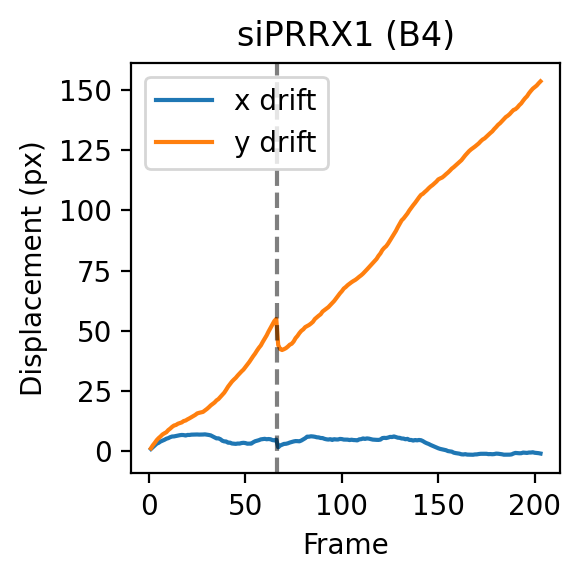

In [19]:
drift = tp.motion.compute_drift(traj, smoothing=0)
print(f"{drift.shape=}")
print(drift.head().to_string())

drift = drift.reset_index()   # make 'frame' a column if not already

plt.figure(figsize=(3,3))
plt.plot(drift["frame"], drift["x"], label="x drift")
plt.plot(drift["frame"], drift["y"], label="y drift")
plt.xlabel("Frame")
plt.ylabel("Displacement (px)")
plt.title(title)
plt.legend()

ax = plt.gca()
ax.axvline(max_time_stage1 + 0.5, ls="--", c="k", alpha=0.5)

plt.tight_layout()
plt.show()

# Rescale Reporters

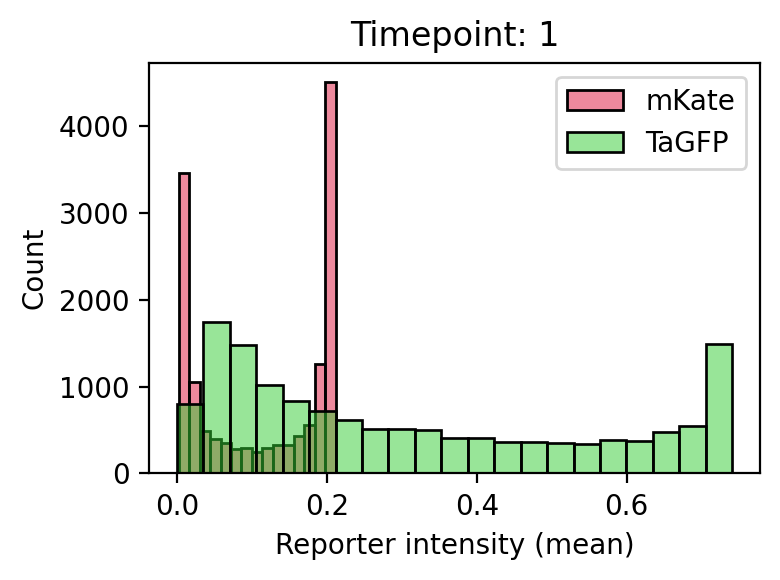

In [20]:
timepoint = 1

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (4, 3)

subset = df[df['time'] == (timepoint - 1)]

sns.histplot(
    data=subset,
    x='mKate_mean',
    color='crimson',   # mKate ~ red/magenta
    alpha=0.5,
    label='mKate'
)

sns.histplot(
    data=subset,
    x='TaGFP_mean',
    color='limegreen',  # GFP ~ green
    alpha=0.5,
    label='TaGFP'
)

plt.title(f"Timepoint: {timepoint}")
plt.xlabel("Reporter intensity (mean)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# apply z-score normalization per particle
traj["mKate_norm"] = (
    traj.groupby("particle")["mKate_mean"]
        .transform(lambda x: (x / x.max()))
)

traj["TaGFP_norm"] = (
    traj.groupby("particle")["TaGFP_mean"]
        .transform(lambda x: (x / x.max()))
)

print(traj[['frame', 'particle','mKate_mean', 'TaGFP_mean', 'TaGFP_norm', 'mKate_norm']].head().to_string())

             frame  particle  mKate_mean  TaGFP_mean  TaGFP_norm  mKate_norm
frame_index                                                                 
0                0         0    0.005698    0.077216    0.168858    0.247761
0                0         1    0.010520    0.675182    1.000000    0.053562
0                0         2    0.135742    0.141047    0.190381    0.678830
0                0         3    0.192298    0.133724    0.495326    0.988365
0                0         4    0.004508    0.052932    0.528108    0.126975


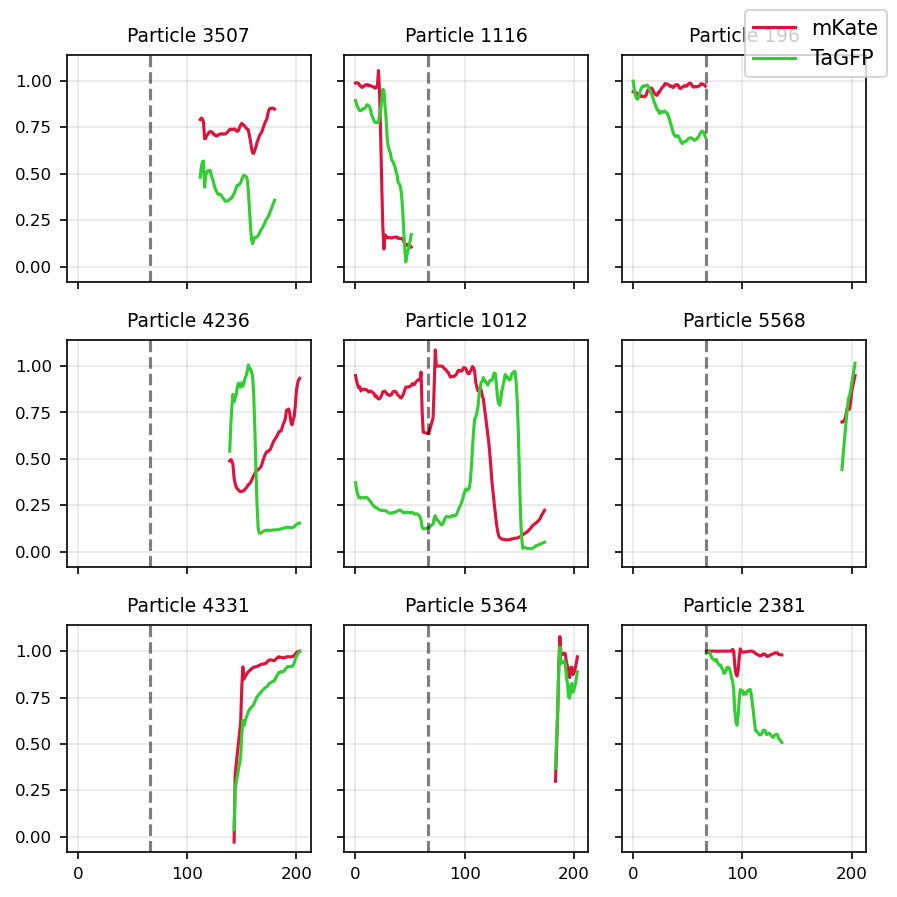

In [22]:
# pick 9 random unique particles
particles = np.random.choice(traj["particle"].unique(), size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(6, 6), dpi=150, sharex=True, sharey=True)

for ax, p in zip(axes.flat, particles):
    sub = traj[traj["particle"] == p].copy()

    # smooth with Savitzky–Golay (window=7 frames, polyorder=2)
    if len(sub) >= 7:  # filter needs enough points
        sub['mKate_smooth'] = savgol_filter(sub['mKate_norm'], 7, 2)
        sub['TaGFP_smooth'] = savgol_filter(sub['TaGFP_norm'], 7, 2)
    else:  # fallback if short trajectory
        sub['mKate_smooth'] = sub['mKate_norm']
        sub['TaGFP_smooth'] = sub['TaGFP_norm']

    # plot
    ax.plot(sub["frame"], sub["mKate_smooth"], color="crimson", label="mKate")
    ax.plot(sub["frame"], sub["TaGFP_smooth"], color="limegreen", label="TaGFP")

    ax.set_title(f"Particle {p}", fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3)
    ax.axvline(max_time_stage1 + 0.5, ls="--", c="k", alpha=0.5)

# one legend outside
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

fig.tight_layout()
plt.show()

# Sample Cell Tracks

In [23]:
df.columns

Index(['label', 'area', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'bbox_area',
       'centroid-0', 'centroid-1', 'eccentricity', 'equivalent_diameter',
       'euler_number', 'extent', 'feret_diameter_max', 'filled_area',
       'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1',
       'local_centroid-0', 'local_centroid-1', 'major_axis_length',
       'minor_axis_length', 'orientation', 'perimeter', 'perimeter_crofton',
       'solidity', 'Cy5_mean', 'Cy5_max', 'Cy5_min', 'centroid_x_px',
       'centroid_y_px', 'centroid_x_um', 'centroid_y_um', 'centroid_unit',
       'Cy5_sum', 'TaGFP_mean', 'TaGFP_max', 'TaGFP_min', 'TaGFP_sum',
       'mKate_mean', 'mKate_max', 'mKate_min', 'mKate_sum', 'time',
       'seg_channel_idx', 'seg_channel_name', 'basename', 'stage', 'condition',
       'scene', 'time_shifted'],
      dtype='object')

particle: sample_idx=3129
	path length: 100


[Text(1, 0.04910507519113885, 'G1: 0.009/0.227'),
 Text(1, 0.5576834185524766, 'S: 0.046/0.070'),
 Text(1, 1.0662617619138144, 'G2/M: 0.101/0.028')]

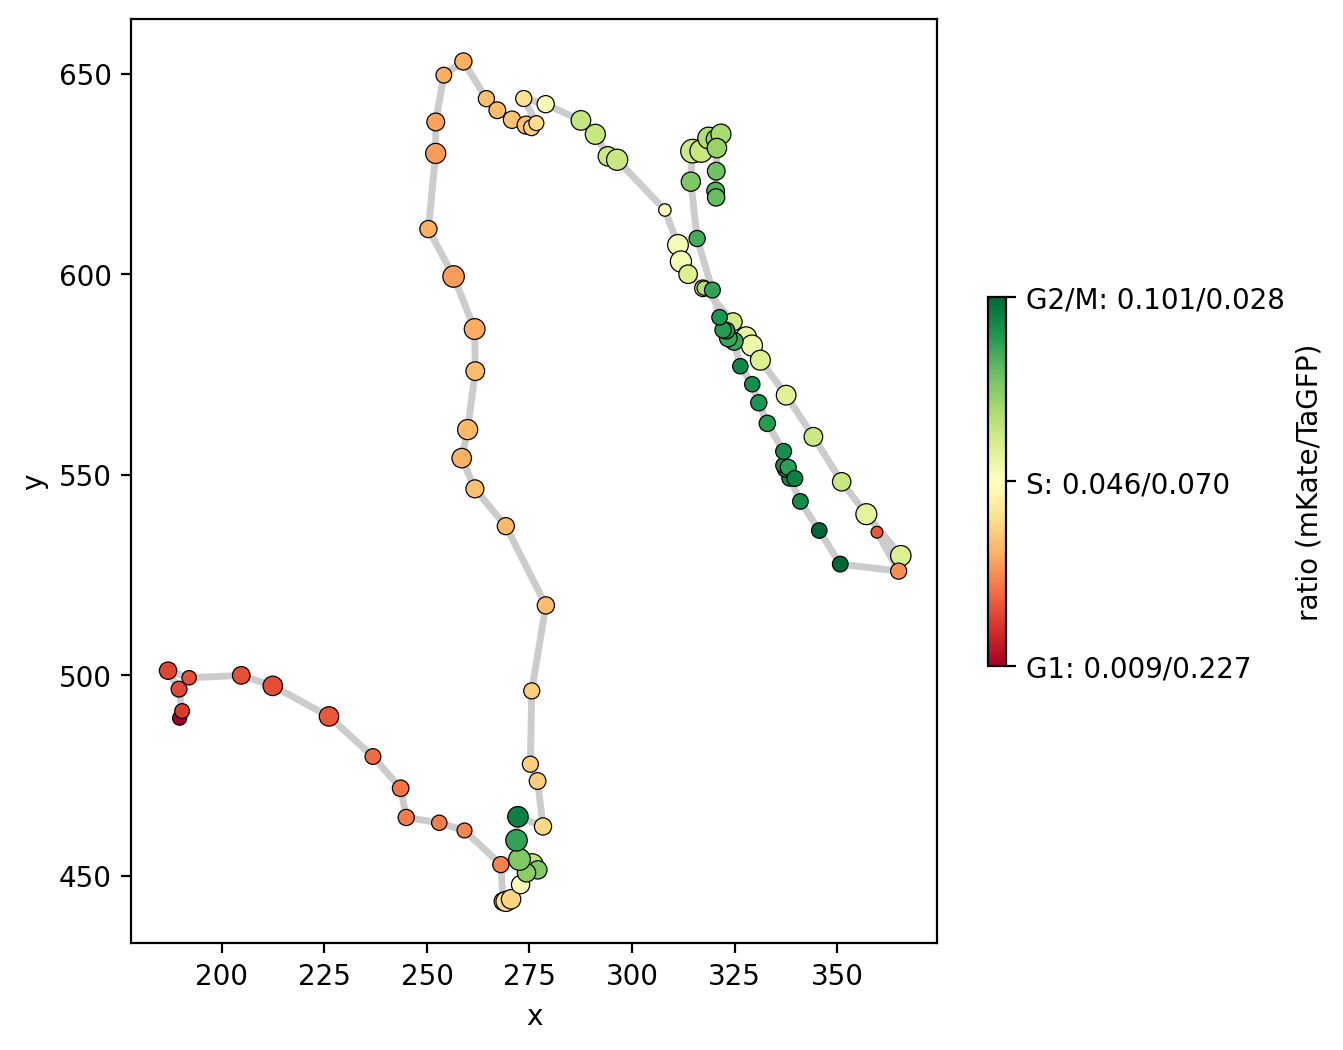

In [24]:
sample_idx = np.random.choice(traj['particle'].unique(), 1)[0]
print(f"particle: {sample_idx=}")

path = traj[traj['particle'] == sample_idx].reset_index()
path = path.sort_values(by='frame')
print(f"\tpath length: {len(path)}")

path['ratio'] = path['mKate_mean'] / path['TaGFP_mean']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6.5, 6

sns.scatterplot(
    data=path,
    x='x',
    y='y',
    hue='ratio', 
    size='filled_area',
    palette='RdYlGn',
    legend=False,
    zorder=3,
    ec='k',
)

ax = plt.gca()

# optional: connect trajectory
ax.plot(
    path['x'], 
    path['y'], 
    lw=2.5, 
    alpha=0.4, 
    color='gray',
    zorder=0,
)

vmin = path['ratio'].min()
vmax = path['ratio'].max()
vmid = 0.5 * (vmin + vmax)

# add a colorbar
sm = plt.cm.ScalarMappable(
    cmap='RdYlGn', 
    norm=plt.Normalize(vmin=path['ratio'].min(),
                       vmax=path['ratio'].max()),
)
cbar = fig.colorbar(
    sm,
    ax=ax,
    label='ratio (mKate/TaGFP)',
    shrink=0.4,
    ticks=[vmin, vmid, vmax],
)

labels = [
    f"G1: {path['mKate_mean'].min():.3f}/{path['TaGFP_mean'].max():.3f}",  # at vmin
    f"S: {path['mKate_mean'].mean():.3f}/{path['TaGFP_mean'].mean():.3f}", # at vmid
    f"G2/M: {path['mKate_mean'].max():.3f}/{path['TaGFP_mean'].min():.3f}"   # at vmax
]

cbar.ax.set_yticklabels(labels)   # if vertical

In [25]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)